# Visualize PCAP Data with Machine Learning

Machine learning has been successful in many domains.  It's been shown repeatedly to be able to learn complex features and patterns.  This is particularly true with image classification and segmentation tasks.

It is hoped that successful ML techniques can be applied to the cybersecurity domain with equally successful outcomes.

## Background

Network data consists of a stream of packets.  Each packet represents an encoded payload of varied application formats (http, bgp, dns, dhcp, smtp, etc).  The state of the network may change over time.  There will be periods of "normal" behavior such as routine connections and data transfers to/from a web server.  There may also be periods of "abnormal" behavior such as a malware attack, denial of service, malformed packets, "arp storms", etc.

All network data can be collected and saved for analysis in PCAP capture files. 

## Hypothesis

A stream of binary PCAP data can be read and formatted into 2D arrays, without regard to the particular protocol of each packet.  As the PCAP stream is ordered by time, the 2D array represents a window of time.  The hypothesis is that unsupervised learning can be used to determine if there are features present in the PCAP data.

## Motivation

Long ago, when mainframe computers filled rooms, they were tended by computer operators.  It was found that the computers gave off large amounts of electromagnetic interference.  An AM radio would easily pick up the interference and play collections of tones that corresponded to the data being processed.  A computer operator would quickly associate the tones with the behavior of the system.  Further, they could easily distinguish normal from abnormal behavior because it did or didn't "sound right."

Feedback and comments are welcome to [gary.huntress@gmail.com](mailto:gary.huntress@gmail.com]




In [36]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
from PIL import Image
import os
from glob import glob

# 50GB of pcap files were obtained from 
# https://www.netresec.com/?page=MACCDC
fnames =glob('/mnt/md0/pcap/*pcap')
 

In [16]:
# read blocks of 260 * 260 * 3 
# save them in x_train 
x_train = []

# hard coding one single file
fname = '/mnt/md0/pcap/maccdc2012_00000.pcap' 
fh = open(fname,'rb')
data = fh.read(260*260*3) # skip one block
while True:
    try:
        data = fh.read(260*260*3)
        fh.seek(-130*260*3,os.SEEK_CUR) # seek back half a block 
        b = np.frombuffer(data,dtype='uint8')
        arr = np.reshape(b[:260*260*3], (260,260,3))
        x_train.append(arr)  

    except Exception as e:
        print(e)  # discard last partial block
        break
        
print("%d image samples" % (len(x_train)))

cannot reshape array of size 154947 into shape (260,260,3)
10585 image samples


## Sample Images

Remeber, they're not really images.  They're formatted blocks of PCAP data.  But we can load and treat them like images.   Lets look at a few and see if they all look the same.  It turns out they do not.  Since they don't look the same it's reasonable to assume they capture different network behavior

<Figure size 432x288 with 0 Axes>

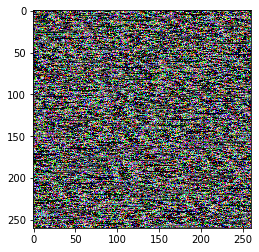

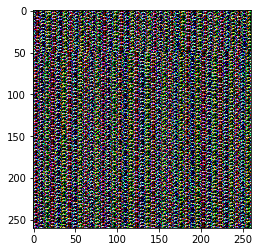

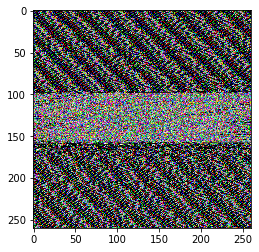

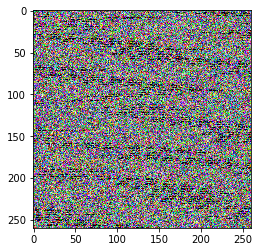

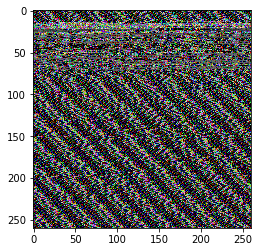

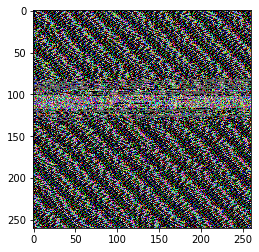

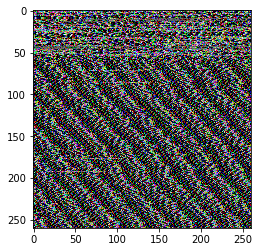

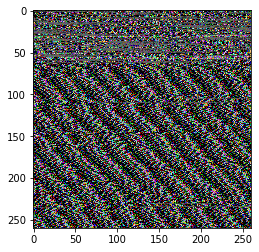

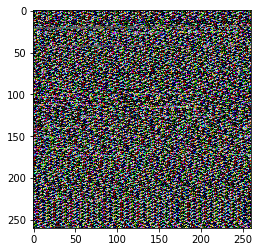

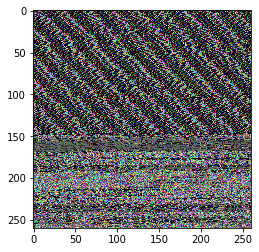

In [34]:

plt.tight_layout()
for x in x_train[0:6000:500]:
    plt.figure()
    plt.imshow(x);

## Unsupervised Machine Learning

A very common approach to unsupervised learning is to use an autoencoder.  This implementation was inspired by the Deep Convolutional Autoencoder found here https://blog.keras.io/building-autoencoders-in-keras.html

The **key concept** is that the full autoencoder begins with a high dimension input, and narrows that down to a layer in the middle that is much smaller.  Then it expands outward again to the same dimension as the input.  The autoencoder tries to make the output exactly the same as the input.  When that happens, the middle smaller layer contains the same information as the high dimension input.

In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(260, 260, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = Dropout(0.1)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 260, 260, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 130, 130, 16)      4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 65, 65, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 65, 65, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 33, 33, 8)         0   

# Train the Model

In [10]:
x_train = np.array(x_train)
x_train= np.reshape(x_train,(x_train.shape[0],260,260,3))
x_train = x_train/np.max(x_train) # normalize 
autoencoder.fit(x_train, x_train, validation_split=0.1, batch_size=64, epochs=5)

Train on 9526 samples, validate on 1059 samples
Epoch 1/5
9526/9526 [==============================] - 816s 86ms/step - loss: 0.6251 - val_loss: 0.6412
Epoch 2/5
9526/9526 [==============================] - 810s 85ms/step - loss: 0.6168 - val_loss: 0.6344
Epoch 3/5
9526/9526 [==============================] - 814s 85ms/step - loss: 0.6144 - val_loss: 0.6340
Epoch 4/5
9526/9526 [==============================] - 811s 85ms/step - loss: 0.6125 - val_loss: 0.6306
Epoch 5/5
9526/9526 [==============================] - 812s 85ms/step - loss: 0.6121 - val_loss: 0.6308


# Capture the Encoding

Next, we define a model that takes the same input, but ends with the output of the "encoded" layer.

In [11]:
encoding = Model(input_img, encoded)
encoding.compile(optimizer='adadelta', loss='binary_crossentropy')
encoding.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 260, 260, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 130, 130, 16)      4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 65, 65, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 65, 65, 8)         1160      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 33, 33, 8)         0   

# Visualization

The full autoencoder is trained at this point.  We now pass all the x_train data through second model using encoding.predict() and capture just the values of the middle layer.  The dimension of that layer is 33*33*8, much lower than 260*260*3.  However, it's still impossible to visualize this data.  We then use UMAP() to transform this data into 2D values.  Then plot the scattergram.


/home/gary/.local/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.local/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


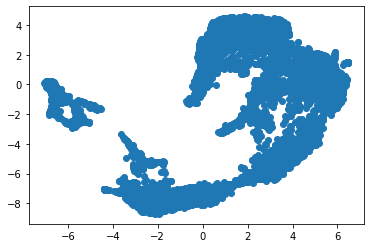

In [41]:
y_hat = encoding.predict(x_train)
y_hat = np.reshape(y_hat,(y_hat.shape[0],33*33*8))

transform = UMAP()
yy = transform.fit_transform(y_hat);

plt.scatter(yy[:,0], yy[:,1]);

That's certainly a big swirl, but does it mean anything?   Typically, if you just have truly random data, tools like UMAP, PCA, and tSNE will just return a boring blob.  This indicates there might be structure, AKA "features".  Lets use a 2D histogram to look for hot spots.

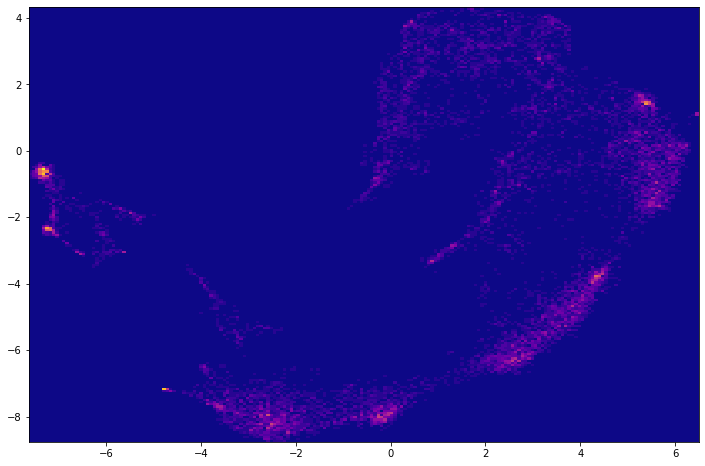

In [13]:
plt.figure(figsize=(12,8))
plt.hist2d(yy[:,0], yy[:,1], bins=200, cmap='plasma');

There are at least a few regions of this histogram that look interesting.  The bright spots indicate areas of higher density where the same features of the autoencoder were found.  It's not possible at this time to classify what they are.  The next step would be for an SME to  retrospectively map the PCAP packets in the bright spots back to the original file and label the network behavior as "normal" or "abnormal" (or other relevant labels).

# Clusters?

The scattergram above are just plots of independent point with no effort made to group them.  There are many tools that will do that.  One category of clustering tools are called density based spatial clustering.   I've chosen to try one called HDBSCAN.

We run the same data through the clusterer and it assigns a label to each point (or an "outlier" id if it cannot).   HDBSCAN has assigned 6 labels to the encoded output of the autoencoder.

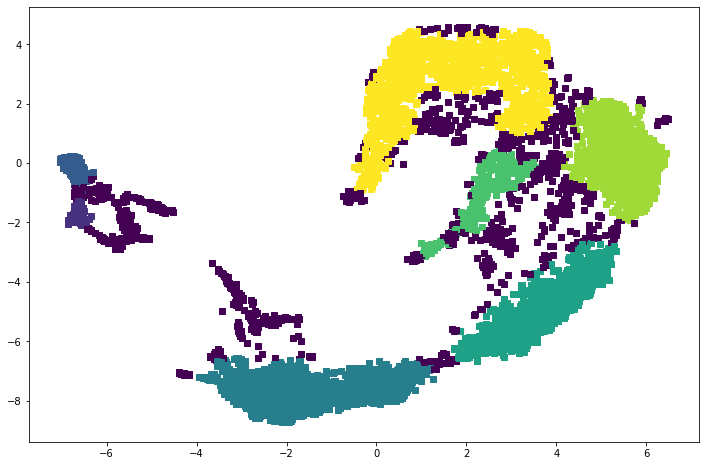

In [45]:
# clusters
import hdbscan

plt.figure(figsize=(12,8))
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
cluster_labels = clusterer.fit_predict(yy)
plt.scatter(yy[:,0],yy[:,1],c=cluster_labels, marker=',')

# Summary

It would appear that it is possible to identify gross features contained in network PCAP files using a CNN autoencoder for unsupervised learning.  A final note is that similar experiments were done by implementing a simple autoencoder with dense layers rather than CNN layers.  Those results were far less successful. 